In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import acf
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15


In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


# Overall Prediction Quality

In [7]:
area = 'all'
pred_val_dict = {}
pred_example_dict = {}

# Calculate total iterations for tqdm
total_iterations = sum(
    len(agent_data[(data_class, agent)]['session_lists'][monkey]['high'])
    for data_class, agent in anesthetic_agent_list
    for monkey in agent_data[(data_class, agent)]['session_lists']
)

with tqdm(total=total_iterations, desc="Processing Sessions") as pbar:
    for data_class, agent in anesthetic_agent_list:
        cfg.params.data_class = data_class
        pred_val_dict[(data_class, agent)] = {}
        pred_example_dict[(data_class, agent)] = {}
        noise_filter_info = agent_data[(data_class, agent)]['noise_filter_info']
        for monkey in agent_data[(data_class, agent)]['session_lists']:
            pred_val_dict[(data_class, agent)][monkey] = {}
            pred_example_dict[(data_class, agent)][monkey] = {}
            for dose in ['high']:
                sessions = agent_data[(data_class, agent)]['session_lists'][monkey][dose]
                pred_val_dict[(data_class, agent)][monkey][dose] = dict(
                    mse=np.zeros(len(sessions)),
                    mse_VAR_small=np.zeros(len(sessions)),
                    mse_VAR=np.zeros(len(sessions)),
                    mse_pb=np.zeros(len(sessions)),
                    aic=np.zeros(len(sessions)),
                    aic_VAR_small=np.zeros(len(sessions)),
                    aic_VAR=np.zeros(len(sessions)),
                    aic_pb=np.zeros(len(sessions)),
                    mase=np.zeros(len(sessions)),
                    mase_VAR_small=np.zeros(len(sessions)),
                    mase_VAR=np.zeros(len(sessions)),
                    mase_pb=np.zeros(len(sessions)),
                )
                pred_example_dict[(data_class, agent)][monkey][dose] = {}
                for ind, session in enumerate(sessions):
                    delase_results = agent_data[(data_class, agent)]['delase_results'][session][area]
                    pred_val_dict[(data_class, agent)][monkey][dose]['mse'][ind] = delase_results.mse_val.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mse_VAR_small'][ind] = delase_results.mse_val_VAR_small.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mse_VAR'][ind] = delase_results.mse_val_VAR.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mse_pb'][ind] = delase_results.mse_val_pb.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['aic'][ind] = delase_results.aic_val.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['aic_VAR_small'][ind] = delase_results.aic_val_VAR_small.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['aic_VAR'][ind] = delase_results.aic_val_VAR.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['aic_pb'][ind] = delase_results.aic_val_pb.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mase'][ind] = delase_results.mase_val.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mase_VAR_small'][ind] = delase_results.mase_val_VAR_small.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mase_VAR'][ind] = delase_results.mase_val_VAR.mean()
                    pred_val_dict[(data_class, agent)][monkey][dose]['mase_pb'][ind] = delase_results.mase_val_pb.mean()
                
                    # ================================================
                    # Get example predictions
                    # ================================================

                    session_noise_filter_info = noise_filter_info[session]
                    
                    if data_class == 'propofolPuffTone':
                        session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class, session + '.mat'), 'r')
                    elif data_class == 'anesthesiaLvrOdd':
                        session_file = h5py.File(os.path.join(cfg.params.all_data_dir, data_class, 'mat', session + '.mat'), 'r')

                    lfp = TransposedDatasetView(session_file['lfp']).transpose()

                    dt = session_file['lfpSchema']['smpInterval'][0, 0]

                    section_info, _, _, infusion_start = get_section_info(session, cfg.params.all_data_dir, data_class, section_info_type='plot')

                    ind = np.where([s[0] == 'Anesthesia' for s in section_info])[0][0]
                    section_start, section_end = section_info[ind][1]

                    # anesthesia_start, anesthesia_end = section_start*60 + infusion_start, section_end*60 + infusion_start
                    window_time = infusion_start + 25
                    # choose the closest time to this window such that there are two valid window
                    # starts in a row
                    valid_starts = session_noise_filter_info['valid_window_starts']
                    window_gap = int(np.diff(valid_starts).min())
                    # Find the closest window such that both this and the next are valid
                    diffs = np.abs(valid_starts - window_time)
                    candidates = np.where((np.arange(len(valid_starts)) < len(valid_starts)-1))[0]
                    # Exclude last because we want two valid in a row
                    best = None
                    min_diff = np.inf
                    for i in candidates:
                        if (valid_starts[i+1] - valid_starts[i]) == window_gap:
                            # If the "window gap" is regular, or just, both windows exist
                            if diffs[i] < min_diff:
                                min_diff = diffs[i]
                                best = i
                    if best is None:
                        # fallback: just take the closest
                        window_ind = diffs.argmin()
                    else:
                        window_ind = best
                    window_time = valid_starts[window_ind]

                    bad_electrodes = session_noise_filter_info['bad_electrodes']
                    good_electrodes = np.setdiff1d(np.arange(lfp.shape[1]), bad_electrodes)

                    iloc_ind = np.where(delase_results.window_start > window_time)[0][0]

                    window_start, window_end = delase_results.window_start.iloc[iloc_ind], delase_results.window_end.iloc[iloc_ind]
                    test_window_start, test_window_end = delase_results.test_window_start.iloc[iloc_ind], delase_results.test_window_end.iloc[iloc_ind]
                    window_start, window_end = int(window_start/dt), int(window_end/dt)
                    test_window_start, test_window_end = int(test_window_start/dt), int(test_window_end/dt)
                    lfp_train = lfp[window_start:window_end, delase_results.dimension_inds.iloc[iloc_ind]]
                    lfp_test = lfp[test_window_start:test_window_end, delase_results.dimension_inds.iloc[iloc_ind]]

                    n_delays, rank = agent_data[(data_class, agent)]['grid_params_to_use'][session][area]['n_delays'], agent_data[(data_class, agent)]['grid_params_to_use'][session][area]['rank']

                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    delase = DeLASE(lfp_train, 
                        n_delays=n_delays,
                        rank=rank,
                        dt=dt*cfg.params.subsample,
                        max_freq=cfg.params.max_freq,
                        max_unstable_freq=cfg.params.max_unstable_freq,
                        device=device,
                        verbose=False
                        )
                    delase.fit()

                    preds_train = delase.DMD.predict(lfp_train)
                    preds_train = preds_train.cpu().numpy()
                    preds_test = delase.DMD.predict(lfp_test)
                    preds_test = preds_test.cpu().numpy()

                    # VAR

                    A = np.linalg.lstsq(lfp_train[:-1], lfp_train[1:], rcond=1e-13)[0].T

                    preds_VAR_train = (A @ lfp_train[:-1].T).T
                    preds_VAR_train = np.vstack((lfp_train[[0]], preds_VAR_train))

                    preds_VAR_test = (A @ lfp_test[:-1].T).T
                    preds_VAR_test = np.vstack((lfp_test[[0]], preds_VAR_test))

                    # VAR small

                    small_window = 500
                    lfp_small = lfp_train[:small_window]
                    lfp_small_test = lfp_train[small_window:2*small_window]
                    A_small = np.linalg.lstsq(lfp_small[:-1], lfp_small[1:], rcond=1e-13)[0].T

                    preds_VAR_small_train = (A_small @ lfp_small[:-1].T).T
                    preds_VAR_small_train = np.vstack((lfp_small[[0]], preds_VAR_small_train))

                    preds_VAR_small_test = (A_small @ lfp_small_test[:-1].T).T
                    preds_VAR_small_test = np.vstack((lfp_small_test[[0]], preds_VAR_small_test))

                    pred_example_dict[(data_class, agent)][monkey][dose][session] = dict(
                        lfp_train=lfp_train,
                        lfp_test=lfp_test,
                        preds_train=preds_train,
                        preds_test=preds_test,
                        preds_VAR_train=preds_VAR_train,
                        preds_VAR_test=preds_VAR_test,
                        preds_VAR_small_train=preds_VAR_small_train,
                        preds_VAR_small_test=preds_VAR_small_test,
                        lfp_small_test=lfp_small_test,
                    )
                    pbar.update(1)

Processing Sessions:   0%|          | 0/53 [00:00<?, ?it/s]

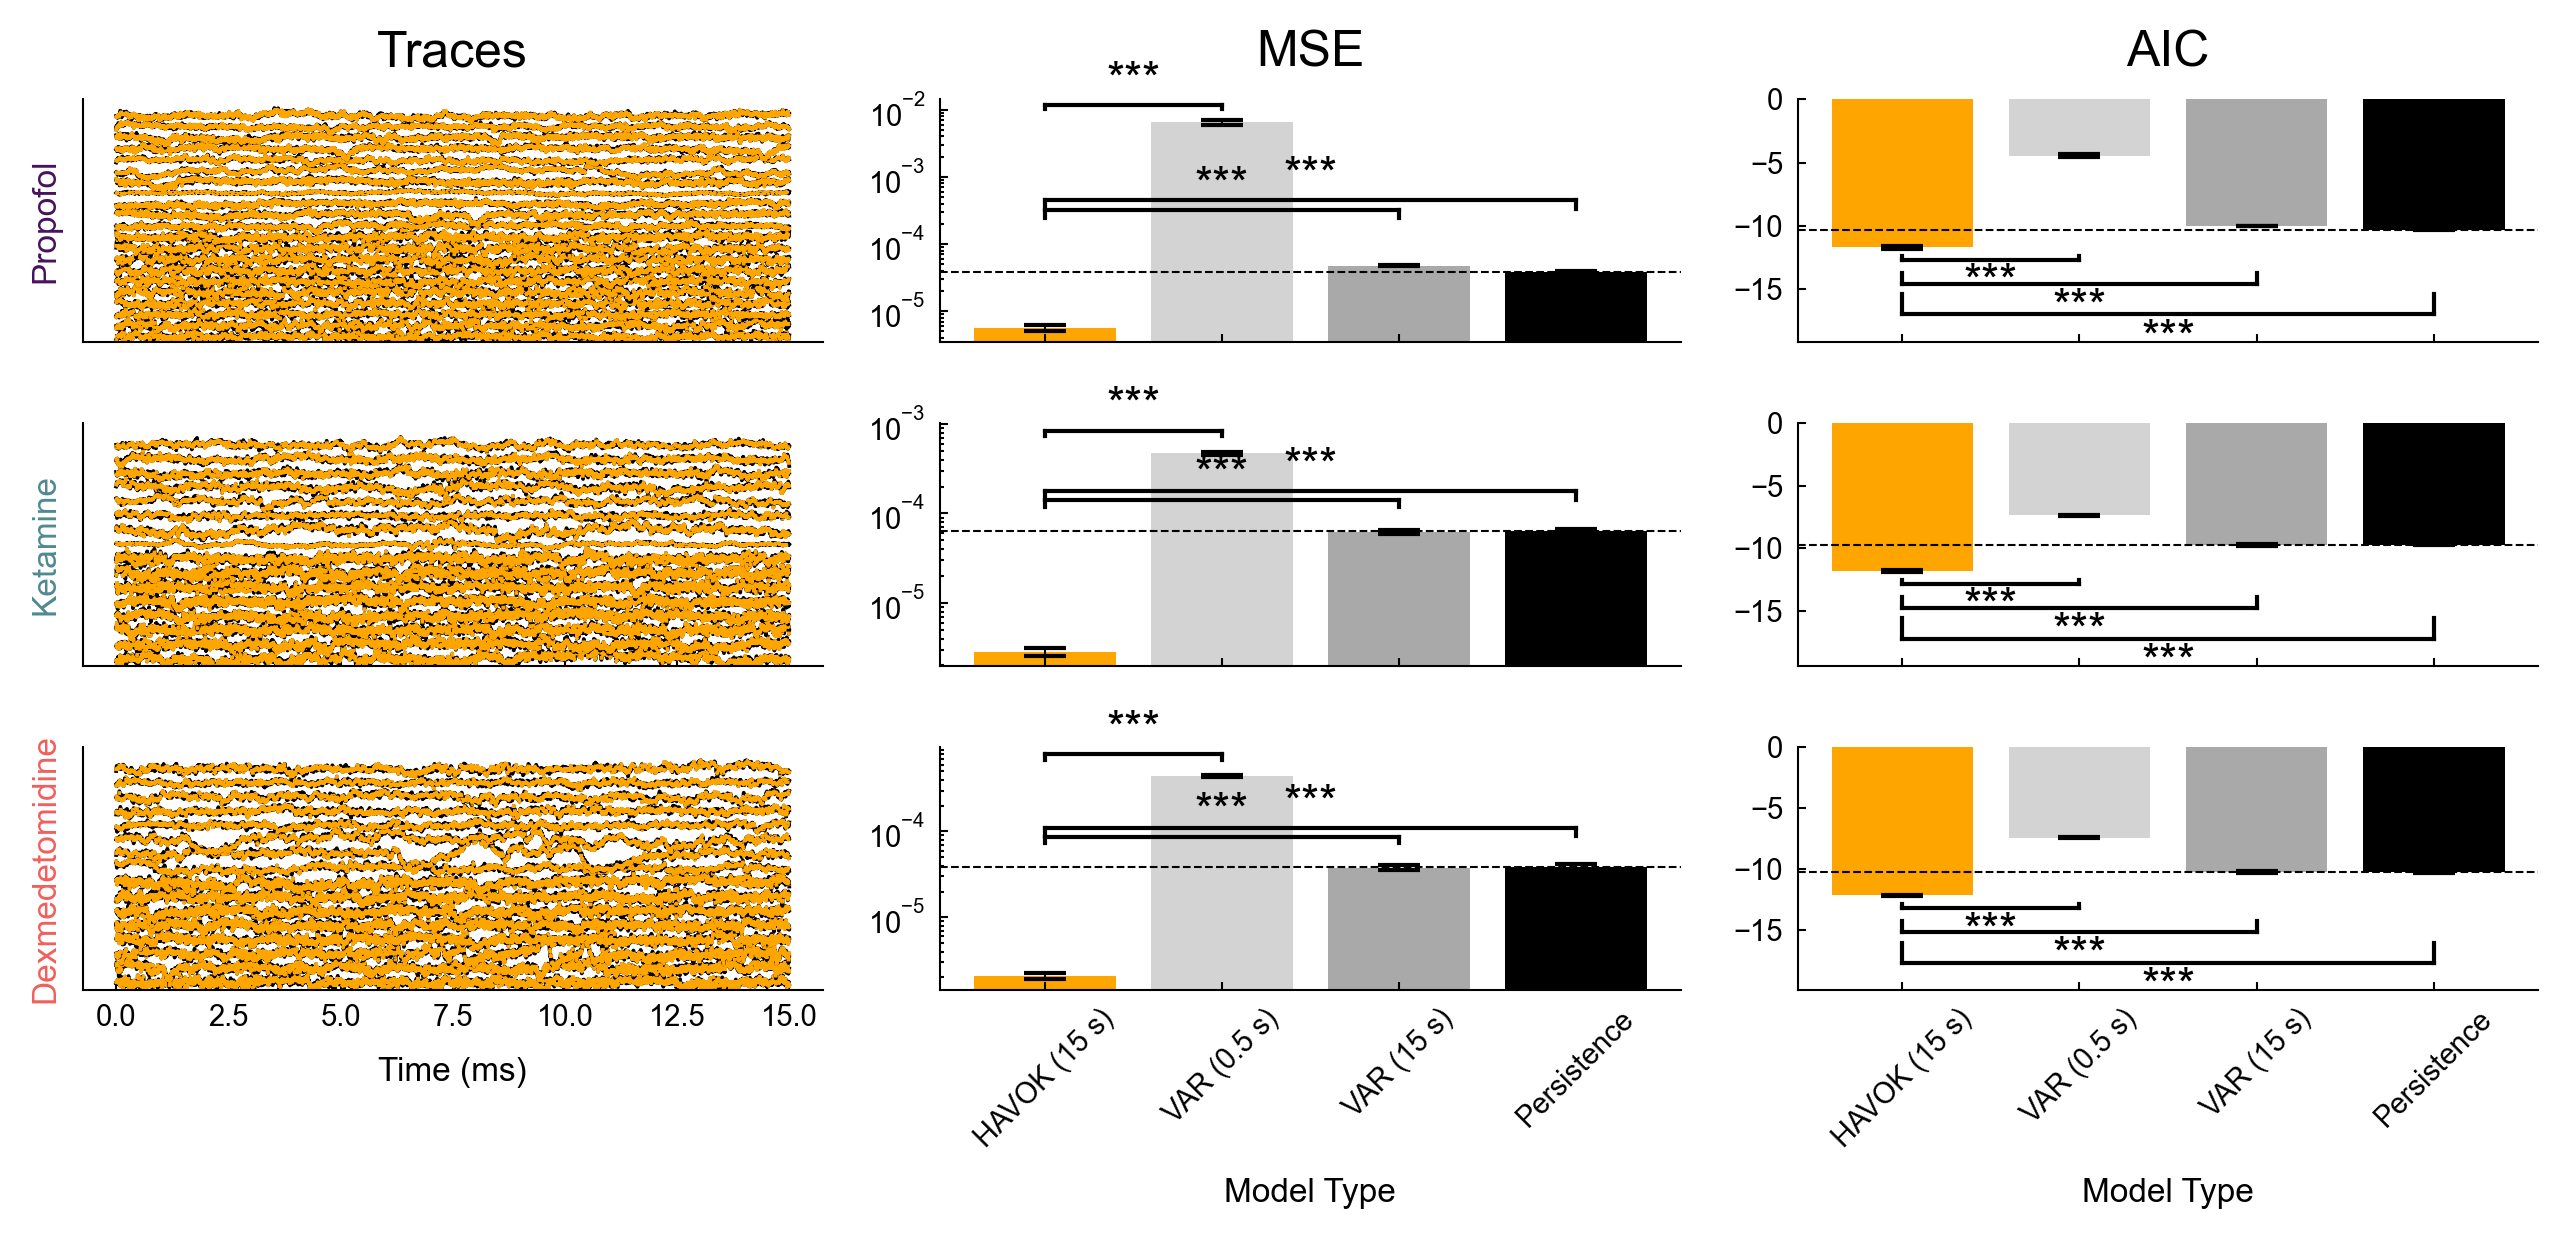

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
from scipy.stats import wilcoxon

# -----------------------
# Font sizing (tweak as needed)
# -----------------------
FONT = {
    'base': 10,
    'title': 12,
    'label': 8,
    'tick': 7,
    'legend': 8,
    'suptitle': 12,
    'sig': 11,
}
plt.rcParams.update({
    'font.size': FONT['base'],
    'axes.titlesize': FONT['title'],
    'axes.labelsize': FONT['label'],
    'xtick.labelsize': FONT['tick'],
    'ytick.labelsize': FONT['tick'],
    'legend.fontsize': FONT['legend'],
    'figure.titlesize': FONT['suptitle'],
})

# Parameters
electrode_index = 0  # select which electrode to show in traces
TRUE_COLOR = 'black'
PRED_COLOR = 'orange'

def standard_error(data):
    return np.std(data) / np.sqrt(len(data))

def select_electrode_trace(arr, electrode_index=0):
    a = np.asarray(arr)
    if a.ndim == 1:
        return a
    if a.ndim == 2:
        eidx = min(max(0, electrode_index), a.shape[1] - 1)
        return a[:, eidx]
    raise ValueError("Expected lfp/preds to be 1D or 2D (time x electrodes).")


def sig_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    return ''


def _compute_bracket_heights(ax, y_base, level, position='above', big_shift=False):
    # position: 'above' or 'below'
    if ax.get_yscale() == 'log':
        # Use multiplicative spacing on log axes for clear separation
        # Increased spacing to prevent overlap: base multiplier increases more with level
        if big_shift:
            base = 1.8 + 5 * level
        else:
            base = 1.8 + 0.5 * level
        if position == 'above':
            y0 = y_base * base
            # For downward-pointing ticks, y1 should be below y0
            # Adjust fraction to make ticks visually similar in size to linear scale
            # Smaller fraction = longer tick (visually on log scale)
            # 0.7 means tick is 30% of distance from y_base to y0, matching AIC's ~30% tick length
            y1 = y_base + (y0 - y_base) * 0.7
        else:  # below
            y0 = y_base / base
            # For upward-pointing ticks, y1 should be above y0
            y1 = y0 * 1.02
    else:
        ylo, yhi = ax.get_ylim()
        yr = yhi - ylo
        offset_main = yr * (0.08 + 0.12 * level)
        offset_tick = yr * 0.03
        if position == 'above':
            y0 = y_base + offset_main
            # For downward-pointing ticks, y1 should be below y0 (closer to y_base)
            y1 = y_base + offset_main * 0.3
        else:  # below
            y0 = y_base - offset_main
            # For upward-pointing ticks, y1 should be above y0
            y1 = y_base - offset_main * 0.7
    return y0, y1


def add_sig_bracket(ax, x1, x2, y_base, level, text, position='above', big_shift=False):
    y0, y1 = _compute_bracket_heights(ax, y_base, level, position=position, big_shift=big_shift)
    ylo, yhi = ax.get_ylim()
    
    # Draw bracket with both ticks pointing downward (for 'above') or upward (for 'below')
    if position == 'above':
        # Horizontal line at top, ticks pointing down
        ax.plot([x1, x2], [y0, y0], color='black', linewidth=1)  # horizontal line
        ax.plot([x1, x1], [y0, y1], color='black', linewidth=1)  # left tick down
        ax.plot([x2, x2], [y0, y1], color='black', linewidth=1)  # right tick down
        # Position stars above the horizontal line
        if ax.get_yscale() == 'log':
            star_y = y0 * 1.05
        else:
            star_y = y0 + (yhi - ylo) * 0.02
        ax.text((x1 + x2) / 2.0, star_y, text, ha='center', va='bottom', fontsize=FONT['sig'])
        # Adjust ylim if star is outside bounds
        if star_y > yhi:
            if ax.get_yscale() == 'log':
                ax.set_ylim(ylo, star_y * 1.15)
            else:
                ax.set_ylim(ylo, star_y + (yhi - ylo) * 0.05)
    else:
        # Horizontal line at bottom, ticks pointing up
        ax.plot([x1, x2], [y0, y0], color='black', linewidth=1)  # horizontal line
        ax.plot([x1, x1], [y0, y1], color='black', linewidth=1)  # left tick up
        ax.plot([x2, x2], [y0, y1], color='black', linewidth=1)  # right tick up
        # Position stars below the horizontal line
        if ax.get_yscale() == 'log':
            star_y = y0 / 1.05
        else:
            star_y = y0 - (yhi - ylo) * 0.02
        ax.text((x1 + x2) / 2.0, star_y, text, ha='center', va='top', fontsize=FONT['sig'])
        # Adjust ylim if star is outside bounds
        if star_y < ylo:
            if ax.get_yscale() == 'log':
                ax.set_ylim(star_y / 1.15, yhi)
            else:
                ax.set_ylim(star_y - (yhi - ylo) * 0.05, yhi)

# Configuration
# metrics = ['mse', 'aic', 'mase']
metrics = ['mse', 'aic']
conditions = ['', 'VAR_small', 'VAR', 'pb']
# condition_names = ['HAVOK\n(15 s window)', 'VAR\n(0.5 s window)', 'VAR\n(15 s window)', 'Persistence\nBaseline']
condition_names = ['HAVOK (15 s)', 'VAR (0.5 s)', 'VAR (15 s)', 'Persistence']
condition_colors = ['orange', 'lightgrey', 'darkgrey', 'black']

# Build a single figure: rows = agents, cols = [traces | metrics...]
num_agents = len(anesthetic_agent_list)
fig, axes = plt.subplots(num_agents, 3, figsize=(9, 4.5), sharex='col')
axes = np.atleast_2d(axes)

x_bar = np.arange(len(conditions))

for row_idx, (data_class, agent) in enumerate(anesthetic_agent_list):
    agent_color = cfg.plotting.curve_colors[agent]

    # -----------------------
    # Left column: session traces (lfp_test vs HAVOK preds) for a single electrode
    # -----------------------
    trace_ax = axes[row_idx, 0]

    sessions_data = []
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for dose in ['high']:
            if (data_class, agent) in pred_example_dict and \
               monkey in pred_example_dict[(data_class, agent)] and \
               dose in pred_example_dict[(data_class, agent)][monkey]:
                for session, sess_data in pred_example_dict[(data_class, agent)][monkey][dose].items():
                    # lfp = select_electrode_trace(sess_data['lfp_test'], electrode_index)
                    # preds = select_electrode_trace(sess_data['preds_test'], electrode_index)
                    lfp = select_electrode_trace(sess_data['lfp_train'], electrode_index)
                    preds = select_electrode_trace(sess_data['preds_train'], electrode_index)
                    sessions_data.append((str(session), lfp, preds))

    if len(sessions_data) == 0:
        trace_ax.text(0.5, 0.5, 'No session traces', transform=trace_ax.transAxes,
                      ha='center', va='center')
        trace_ax.set_title('Traces')
        trace_ax.set_xlabel('Time (samples)')
        trace_ax.set_yticks([])
    else:
        amplitude_estimates = []
        for _, lfp, _ in sessions_data:
            if lfp.size > 0:
                lo = np.nanpercentile(lfp, 5)
                hi = np.nanpercentile(lfp, 95)
                amplitude_estimates.append(max(hi - lo, 1e-6))
        y_spacing = (np.median(amplitude_estimates) if len(amplitude_estimates) > 0 else 1.0) * 1.5

        ytick_positions = []
        ytick_labels = []
        for idx, (sess_name, lfp, preds) in enumerate(sessions_data):
            n = int(min(len(lfp), len(preds)))
            if n == 0:
                continue
            x = np.arange(n)*0.001
            offset = idx * y_spacing
            ytick_positions.append(offset)
            ytick_labels.append(sess_name)

            trace_ax.plot(x, lfp[:n] + offset, color=TRUE_COLOR, linewidth=0.9)
            trace_ax.plot(x, preds[:n] + offset, color=PRED_COLOR, linewidth=0.9, linestyle=':')

        if row_idx == 0:
            trace_ax.set_title('Traces', fontsize=FONT['title'])
        elif row_idx == len(anesthetic_agent_list) - 1:
            trace_ax.set_xlabel('Time (ms)', fontsize=FONT['label'])
            # trace_ax.set_ylabel('Sessions (offset)', fontsize=FONT['label'])
            # if len(ytick_positions) <= 20:
            #     trace_ax.set_yticks(ytick_positions)
        #     trace_ax.set_yticklabels(ytick_labels, fontsize=FONT['tick'])
        # else:
        #     trace_ax.set_yticks([])
        trace_ax.set_yticks([])
        ymin = -0.5 * y_spacing
        ymax = (len(sessions_data) + 0.5) * y_spacing
        trace_ax.set_ylim(ymin, ymax)
        trace_ax.tick_params(axis='both', labelsize=FONT['tick'])

    # Agent label along the leftmost subplot
    trace_ax.text(-0.05, 0.5, agent.capitalize(),
                  transform=trace_ax.transAxes,
                  rotation=90, va='center', ha='center',
                  color=agent_color, fontsize=FONT['label'])

    # -----------------------
    # Metric columns: 1..3
    # -----------------------
    mean_values = {metric: [] for metric in metrics}
    stderr_values = {metric: [] for metric in metrics}
    all_values = {metric: {condition: [] for condition in conditions} for metric in metrics}

    for metric in metrics:
        for condition in conditions:
            values = []
            for monkey in agent_data[(data_class, agent)]['session_lists']:
                for dose in ['high']:
                    key = metric + '_' + condition if condition != '' else metric
                    values.extend(pred_val_dict[(data_class, agent)][monkey][dose][key])
            mean_values[metric].append(np.mean(values))
            stderr_values[metric].append(standard_error(values))
            all_values[metric][condition] = values

    for col_offset, metric in enumerate(metrics):
        ax = axes[row_idx, 1 + col_offset]

        ax.bar(x_bar, mean_values[metric], yerr=stderr_values[metric],
               capsize=5, color=condition_colors)

        if row_idx == 0:
            ax.set_title(metric.upper(), fontsize=FONT['title'])
        elif row_idx == len(anesthetic_agent_list) - 1:
            ax.set_xlabel('Model Type', fontsize=FONT['label'])
            # ax.set_ylabel('Mean Across Sessions', fontsize=FONT['label'])
        if metric != 'aic':
            ax.set_yscale('log')

        ax.xaxis.set_major_locator(FixedLocator(range(len(conditions))))
        ax.set_xticklabels(condition_names, rotation=45, ha='center', fontsize=FONT['tick'])
        ax.tick_params(axis='y', labelsize=FONT['tick'])

        ax.axhline(mean_values[metric][-1], color='black', linestyle='--')

        # Significance: HAVOK vs each other model (lower is better)
        havok_values = all_values[metric]['']
        for level, idx_other in enumerate([1, 2, 3]):
            other_key = conditions[idx_other]
            try:
                _, p_value = wilcoxon(havok_values, all_values[metric][other_key], alternative='less')
            except ValueError:
                continue
            stars = sig_stars(p_value)
            if not stars:
                continue
            if metric == 'aic':
                y_base = min(mean_values[metric][0], mean_values[metric][idx_other])
                add_sig_bracket(ax, 0, idx_other, y_base, level, stars, position='below')
                ylim = ax.get_ylim()
                ax.set_ylim(ylim[0] - 1, ylim[1])
            else:
                y_base = max(mean_values[metric][0], mean_values[metric][idx_other])
                if row_idx == 0:
                    big_shift = True
                else:
                    big_shift = False
                add_sig_bracket(ax, 0, idx_other, y_base, level, stars, position='above', big_shift=big_shift)

# fig.suptitle('Prediction Quality by Agent: Session Traces and Metrics', y=0.995, fontsize=FONT['suptitle'])
plt.tight_layout(rect=[0.02, 0.04, 0.98, 0.98])
plt.savefig(os.path.join(cfg.plotting.img_save_dir, 'supp', f'prediction_quality.pdf'), transparent=True, bbox_inches='tight')
plt.show()

# Cross Timepoint Prediction Quality

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
area = 'all'
session_window_times = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
# session_window_times = [-15, -5, 0, 20, 40, 60, 80]

In [11]:
# DO NOT DELETE

# # Prereqs (run once if needed)
# # %pip install -q joblib tqdm tqdm-joblib

# import os
# import multiprocessing as mp
# from typing import Tuple
# import numpy as np
# import h5py
# from joblib import Parallel, delayed
# from tqdm import tqdm
# from tqdm_joblib import tqdm_joblib

# # Performance: avoid BLAS oversubscription (set before heavy math)
# os.environ.setdefault("OMP_NUM_THREADS", "1")
# os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
# os.environ.setdefault("MKL_NUM_THREADS", "1")
# os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# # This cell assumes the following already exist in your notebook:
# # - anesthetic_agent_list, agent_data, cfg, area, session_window_times
# # - DeLASE, TransposedDatasetView, get_section_info
# # - device (e.g., "cpu", torch.device("cuda"), etc.)

# OUTPUT_BASE = "/om/weka/millerlab/eisenaj/UniversalUnconsciousness/prediction_comparisons"

# def _mat_path_for_session(data_class: str, session: str) -> str:
#     if data_class == "propofolPuffTone":
#         return os.path.join(cfg.params.all_data_dir, "anesthesia", "mat", data_class, session + ".mat")
#     elif data_class == "anesthesiaLvrOdd":
#         return os.path.join(cfg.params.all_data_dir, data_class, "mat", session + ".mat")
#     raise ValueError(f"Unhandled data_class: {data_class}")

# def _out_path_for_session(data_class: str, session: str) -> str:
#     out_dir = os.path.join(OUTPUT_BASE, data_class)
#     os.makedirs(out_dir, exist_ok=True)
#     return os.path.join(out_dir, f"{session}.npy")

# def _atomic_save_npy(path: str, arr: np.ndarray) -> None:
#     # Ensure directory exists (defensive in case caller changes)
#     os.makedirs(os.path.dirname(path), exist_ok=True)
#     # Use a temp that also ends with .npy so NumPy won't append another suffix
#     tmp = path + ".part.npy"
#     np.save(tmp, arr)
#     os.replace(tmp, path)

# def compute_and_save_cross_mse_for_session(
#     data_class: str,
#     agent: str,
#     monkey: str,
#     session: str,
#     area: str,
#     session_window_times: np.ndarray
# ) -> Tuple[str, bool, str]:
#     out_path = _out_path_for_session(data_class, session)
#     if os.path.exists(out_path):
#         return (session, False, out_path)  # skipped

#     # Gather per-session params
#     delase_results = agent_data[(data_class, agent)]["delase_results"][session][area]
#     grid_params = agent_data[(data_class, agent)]["grid_params_to_use"][session][area]
#     n_delays, rank = grid_params["n_delays"], grid_params["rank"]

#     # Open HDF5 file inside the worker
#     fpath = _mat_path_for_session(data_class, session)
#     with h5py.File(fpath, "r") as session_file:
#         lfp = TransposedDatasetView(session_file["lfp"]).transpose()
#         dt = session_file["lfpSchema"]["smpInterval"][0, 0]
#         _, _, _, infusion_start = get_section_info(session, cfg.params.all_data_dir, data_class, section_info_type="plot")

#         T = len(session_window_times)
#         cross_mse_matrix = np.zeros((T, T), dtype=float)

#         # Build DeLASE once per i (as in your original loop)
#         for i, t_i in enumerate(session_window_times):
#             ind_i = (np.arange(len(delase_results))[np.argmin(np.abs((delase_results.window_start - infusion_start)/60 - t_i))])
#             row_i = delase_results.iloc[ind_i]
#             lfp_i = lfp[int(row_i.window_start/dt): int(row_i.window_end/dt), row_i.dimension_inds]

#             delase = DeLASE(
#                 lfp_i,
#                 n_delays=n_delays,
#                 rank=rank,
#                 dt=dt * cfg.params.subsample,
#                 max_freq=cfg.params.max_freq,
#                 max_unstable_freq=cfg.params.max_unstable_freq,
#                 device=device,
#                 verbose=False,
#             )
#             delase.DMD.compute_hankel()
#             delase.DMD.compute_svd()
#             delase.DMD.compute_havok_dmd()

#             for j, t_j in enumerate(session_window_times):
#                 ind_j = (np.arange(len(delase_results))[np.argmin(np.abs((delase_results.window_start - infusion_start)/60 - t_j))])
#                 row_j = delase_results.iloc[ind_j]
#                 lfp_j = lfp[int(row_j.window_start/dt): int(row_j.window_end/dt), row_j.dimension_inds]
#                 preds_j = delase.DMD.predict(lfp_j).cpu().numpy()
#                 cross_mse_matrix[i, j] = np.mean((preds_j - lfp_j) ** 2)

#     _atomic_save_npy(out_path, cross_mse_matrix)
#     return (session, True, out_path)  # saved

# # Build task list
# tasks = []
# for data_class, agent in anesthetic_agent_list:
#     for monkey in agent_data[(data_class, agent)]["session_lists"]:
#         for session in agent_data[(data_class, agent)]["session_lists"][monkey]["high"]:
#             tasks.append((data_class, agent, monkey, session))

# num_sessions = len(tasks)

# # Decide n_jobs based on SLURM allocation/GPU usage
# def available_cpus() -> int:
#     try:
#         return len(os.sched_getaffinity(0))
#     except Exception:
#         return mp.cpu_count()

# aff = available_cpus()
# env_cap = int(os.environ.get("N_JOBS", "0")) or None  # optional manual cap via env
# is_gpu = "cuda" in str(device).lower() or "gpu" in str(device).lower()

# if is_gpu:
#     # GPU-bound: keep small to avoid GPU memory contention
#     default_n_jobs = min(2, num_sessions)
# else:
#     default_n_jobs = min(aff, num_sessions)

# n_jobs = default_n_jobs if env_cap is None else max(1, min(default_n_jobs, env_cap))

# print(f"[Parallel config] sessions={num_sessions}, available_cpus={aff}, gpu={is_gpu}, n_jobs={n_jobs}")
# print(f"[Output] base={OUTPUT_BASE}")

# # Run in parallel with a progress bar
# with tqdm_joblib(tqdm(total=len(tasks), desc="Sessions", smoothing=0.1)):
#     results = Parallel(n_jobs=n_jobs, backend="loky")(
#         delayed(compute_and_save_cross_mse_for_session)(dc, ag, mk, ss, area, session_window_times)
#         for (dc, ag, mk, ss) in tasks
#     )

# # Summarize
# saved = sum(1 for _, s, _ in results if s)
# skipped = len(results) - saved
# print(f"Saved: {saved}, Skipped (already existed): {skipped}")
# if saved:
#     print("Example saved path:", next(p for _, s, p in results if s))
# if skipped:
#     print("Example skipped path:", next(p for _, s, p in results if not s))

In [14]:
from collections import Counter

OUTPUT_BASE = "/om/weka/millerlab/eisenaj/UniversalUnconsciousness/prediction_comparisons"

def _npy_path(data_class: str, session: str) -> str:
    return os.path.join(OUTPUT_BASE, data_class, f"{session}.npy")

def _choose_ticks(times, n=6):
    times = np.asarray(times).astype(float)
    if len(times) <= n:
        idxs = list(range(len(times)))
    else:
        idxs = list(np.unique(np.round(np.linspace(0, len(times) - 1, n)).astype(int)))
    labels = [round(float(times[i]), 2) for i in idxs]
    return idxs, labels


mean_matrices = {}
counts = {}
missing_counter = 0

for data_class, agent in anesthetic_agent_list:
    session_lists = agent_data[(data_class, agent)]["session_lists"]
    for monkey in session_lists:
        session_ids = session_lists[monkey]["high"]
        mats = []
        shapes = []
        for session in session_ids:
            path = _npy_path(data_class, session)
            if not os.path.exists(path):
                missing_counter += 1
                continue
            try:
                m = np.load(path, allow_pickle=False)
            except Exception:
                continue
            mats.append(m)
            shapes.append(m.shape)

        if not mats:
            continue

        # Ensure consistent shapes (keep most common shape)
        common_shape = Counter(shapes).most_common(1)[0][0]
        mats = [m for m in mats if m.shape == common_shape]
        if not mats:
            continue

        mean_matrices[(data_class, agent, monkey)] = np.mean(mats, axis=0)
        counts[(data_class, agent, monkey)] = len(mats)

print(f"Found means for {len(mean_matrices)} agent/monkey combos. Missing files skipped: {missing_counter}")

Found means for 6 agent/monkey combos. Missing files skipped: 0


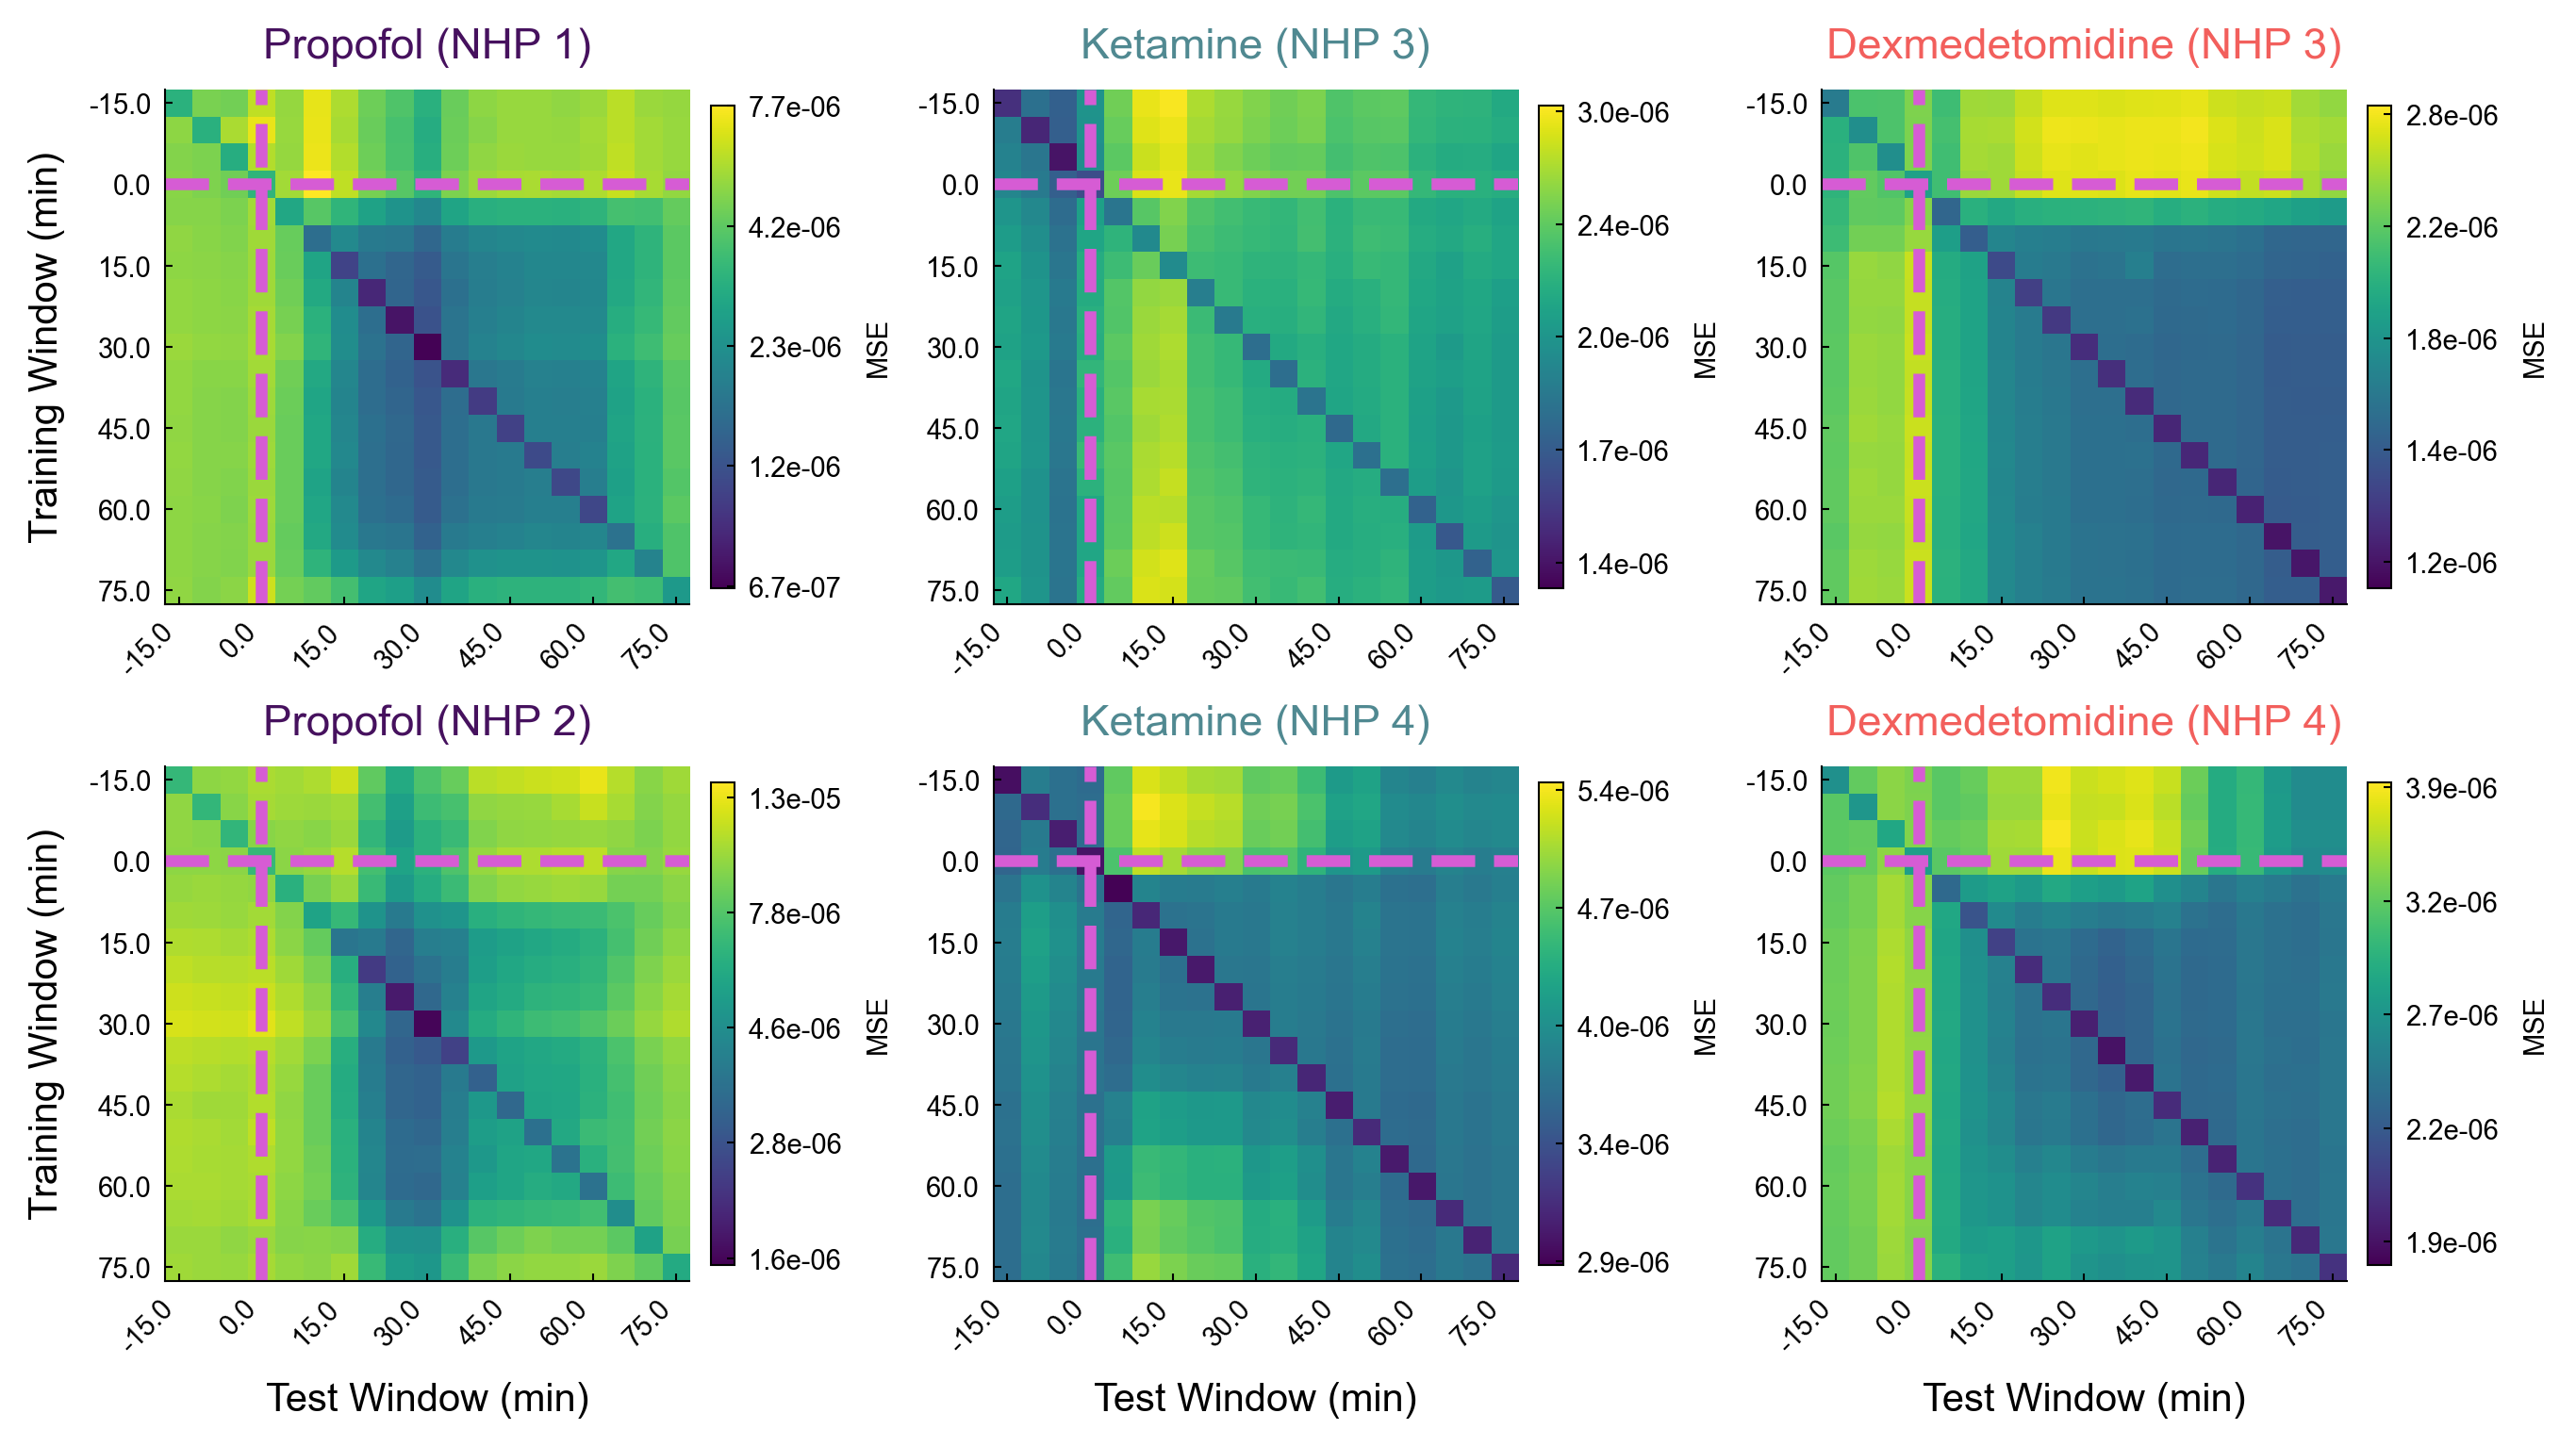

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

# Requires (must already exist in the notebook runtime):
# - mean_matrices: Dict[(data_class, agent, monkey) -> np.ndarray]
# - counts: Dict[(data_class, agent, monkey) -> int]
# - session_window_times: 1D array-like of window times (minutes rel. infusion start)
# - anesthetic_agent_list: List[(data_class, agent)] with exactly 3 unique agents

# Font sizes
FONT = {
    'title': 11,
    'label': 10,
    'tick': 7,
    'cbar': 7,
}

def _choose_ticks(times, n=6):
    times = np.asarray(times, dtype=float)
    if len(times) <= n:
        idxs = list(range(len(times)))
    else:
        idxs = list(np.unique(np.round(np.linspace(0, len(times) - 1, n)).astype(int)))
    labels = [round(float(times[i]), 2) for i in idxs]
    return idxs, labels

def _log_norm_for(mat):
    pos = mat[mat > 0]
    if pos.size == 0:
        vmin = 1e-12
    else:
        vmin = max(1e-12, float(np.nanmin(pos)))
    vmax = float(np.nanmax(mat)) if np.isfinite(np.nanmax(mat)) else vmin * 10.0
    if vmax <= vmin:
        vmax = vmin * 10.0
    exp_min = int(str(vmin).split('e')[1])
    exp_max = int(str(vmax).split('e')[1])

    vmin2 = (np.floor(float(str(vmin).split('e')[0])*10)/10)*10**exp_min
    vmax2 = (np.ceil(float(str(vmax).split('e')[0])*10)/10)*10**exp_max
    
    ticks = np.geomspace(vmin, vmax, num=5)
    return LogNorm(vmin=vmin2, vmax=vmax2), vmin2, vmax2, ticks

# # Ensure readable log ticks even for narrow dynamic ranges
# # Returns a list of tick values in [vmin, vmax] (at least 3 when possible)
# def _nice_log_ticks(vmin, vmax):
#     if vmin <= 0 or not np.isfinite(vmin) or not np.isfinite(vmax):
#         return None
#     exp_min = int(np.floor(np.log10(vmin)))
#     exp_max = int(np.ceil(np.log10(vmax)))
#     print(exp_min, exp_max)
#     subs = np.array([1.0, 1.5, 2.0, 3.0, 5.0, 7.0])
#     ticks = []
#     for e in range(exp_min, exp_max + 1):
#         vals = subs * (10.0 ** e)
#         ticks.extend([v for v in vals if (v >= vmin) and (v <= vmax)])
#     if len(ticks) < 3:
#         ticks = list(np.geomspace(vmin, vmax, num=3))
#     return ticks

# Ticks
xticks_idx, xticks_lbls = _choose_ticks(session_window_times, n=7)
yticks_idx, yticks_lbls = _choose_ticks(session_window_times, n=7)

# Get the 3 agents in order of appearance
agents_order = []
for _, agent in anesthetic_agent_list:
    if agent not in agents_order:
        agents_order.append(agent)
agents = agents_order[:3]  # guaranteed 3

# Build a single 2x3 figure: rows = monkey index (per agent), cols = agents
fig, axes = plt.subplots(2, 3, figsize=(9, 5), constrained_layout=True)
axes = np.asarray(axes)

# No suptitle (removed)

for c, agent in enumerate(agents):
    # Get this agent's two monkeys (union over data_classes), sorted for consistency
    monkeys = sorted({mk for (dc, ag, mk) in mean_matrices.keys() if ag == agent})
    # Expect exactly 2 monkeys
    if len(monkeys) != 2:
        raise ValueError(f"Agent {agent} has {len(monkeys)} monkeys in data; expected exactly 2.")
    for r, monkey in enumerate(monkeys):
        ax = axes[r, c]

        # Aggregate across all data_classes for this (agent, monkey)
        mats = []
        total_n = 0
        for (dc, ag, mk), mat in mean_matrices.items():
            if ag == agent and mk == monkey:
                mats.append(mat)
                total_n += counts.get((dc, agent, monkey), 0)

        if len(mats) == 0:
            raise ValueError(f"No matrices found for agent={agent}, monkey={monkey}.")

        mat = np.nanmean(np.stack(mats, axis=0), axis=0)

        # Per-subplot log scaling
        norm, vmin, vmax, ticks = _log_norm_for(mat)
        eps = max(1e-12, vmin * 1e-6)
        im = ax.imshow(mat + eps, cmap="viridis", norm=norm, aspect="auto", origin="upper")

        # Title shows agent | NHP index and total count across classes (bigger font)
        NHP_num = r + 1 if agent == 'propofol' else r + 3
        ax.set_title(f"{agent.capitalize()} (NHP {NHP_num})", fontsize=FONT['title'], color=cfg.plotting.curve_colors[agent])

        zero_loc_y = yticks_idx[np.argmin(np.abs(np.array(yticks_lbls) - 0))]
        zero_loc_x = xticks_idx[np.argmin(np.abs(np.array(xticks_lbls) - 0))]
        ax.axhline(zero_loc_y, color=cfg.plotting.epoch_colors['anesthesia'], linestyle='--', linewidth=3)
        ax.axvline(zero_loc_x, color=cfg.plotting.epoch_colors['anesthesia'], linestyle='--', linewidth=3)

        # Axes labels/ticks: y-label only on left column; x-label only on bottom row
        if c == 0:
            ax.set_ylabel("Training Window (min)", fontsize=FONT['label'])
        if r == 1:
            ax.set_xlabel("Test Window (min)", fontsize=FONT['label'])

        ax.set_xticks(xticks_idx)
        ax.set_xticklabels(xticks_lbls, rotation=45, ha="right", fontsize=FONT['tick'])
        ax.set_yticks(yticks_idx)
        ax.set_yticklabels(yticks_lbls, fontsize=FONT['tick'])

        # Colorbar per subplot (compact scientific tick labels)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        if ticks is not None:
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([f'{t:.1e}' for t in ticks])
        # cbar.ax.yaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
        cbar.minorticks_off()
        # cbar.update_ticks()
        # get cbar limits
        cbar.ax.tick_params(which='both', labelsize=FONT['cbar'])
        cbar.ax.set_ylabel('MSE', fontsize=FONT['cbar'])

plt.savefig(os.path.join(cfg.plotting.img_save_dir, 'supp', f'cross-timepoint-prediction-quality.pdf'), transparent=True, bbox_inches='tight')
plt.show()